<a id="introduction"></a>
# Analysis of coupled rhythms *for the practicing neuroscientist*

<div class="question">
    
_**Synopsis**_ 

**Data:** 1 s of ECoG data sampled at 500 Hz from two electrodes for 100 trials.

**Goal:** Characterize the coupling of rhythmic activity between the two electrodes.

**Tools:** Fourier transform, spectrum, amplitude, coherence, phase.

    
</div>

* [Background](#background)
* [Case Study Data](#case-study-data)
* [Data Analysis](#data-analysis)
    * [Visual Inspection](#visual-inspection)
    * [Autocovariance and Cross-covariance](#Autocovariance-and-Cross-covariance)
    * [Trial-Averaged Spectrum](#Trial-Averaged-Spectrum)
* [Introduction to the Coherence](#sec:coherence)
    * [Simple Scenario 1: Phases align across trials](#Simple_Scenario_1)
    * [Simple Scenario 2: Phases are random across trials](#Simple_Scenario_2)
    * [Summary of the coherence](#Summary_of_the_coherence)
* [Cross-Covariance and Cross-Spectrum](#cc_and_cs)
* [Computing the Coherence](#computing_coherence)
    * [Visualizing the Phase Difference across Trials](#Visualizing_the_Phase_Difference)
    * [Single-Trial Coherence](#single_trial_coherence)
* [Relation between Statistical Modeling and Coherence](#Relation_between_Statistical_Modeling_and_Coherence)
* [Summary](#summary)    

## On-ramp: computing the coherence in Python
We begin this module with an "*on-ramp*" to analysis. The purpose of this on-ramp is to introduce you immediately to a core concept in this module: how to compute the coherence in Python. You may not understand all aspects of the program here, but that's not the point. Instead, the purpose of this on-ramp is to illustrate what *can* be done. Our advice is to simply run the code below and see what happens ...

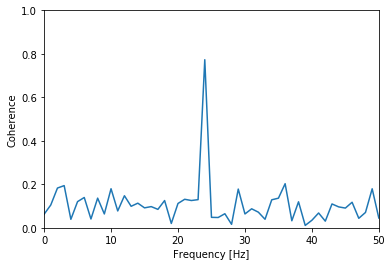

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = sio.loadmat('ECoG-1.mat')                  # Load the data,
E1 = data['E1']                                   # ... from the first electrode,
E2 = data['E2']                                   # ... and from the second electrode.
t = data['t'][0]                                  # Load the time axis,
dt = t[1]-t[0]                                    # ... to get the sampling interval,
T = t[-1]                                         # ... and the total time of the recording.
K,N = np.shape(E1)                                # Get the number of trials, and number of pts per trial.

Sxx = np.zeros([K,int(N/2+1)])		              # Create variables to save the spectra,
Syy = np.zeros([K,int(N/2+1)])
Sxy = np.zeros([K,int(N/2+1)], dtype=complex)
for k in range(K):			                      # For each trial,
    x=E1[k,:]-np.mean(E1[k,:])                    # ... get the data from each electrode,
    y=E2[k,:]-np.mean(E2[k,:])
    xf  = np.fft.rfft(x-np.mean(x))               # ... compute Fourier transform,
    yf  = np.fft.rfft(y-np.mean(y))
    Sxx[k,:] = 2*dt**2/T *np.real(xf*np.conj(xf)) # ... and compute the spectra.
    Syy[k,:] = 2*dt**2/T *np.real(yf*np.conj(yf))
    Sxy[k,:] = 2*dt**2/T *       (xf*np.conj(yf))

Sxx = np.mean(Sxx,0)		                      # Average the spectra across trials,
Syy = np.mean(Syy,0)
Sxy = np.mean(Sxy,0)

cohr = np.abs(Sxy) / (np.sqrt(Sxx) * np.sqrt(Syy))# ... and compute the coherence.

f = np.fft.rfftfreq(N, dt)                        # Define a frequency axis.
plt.plot(f, cohr);		                          # Plot coherence vs frequency,
plt.xlim([0, 50])			                      # ... in a chosen frequency range,
plt.ylim([0, 1])                                  # ... with y-axis scaled,
plt.xlabel('Frequency [Hz]')                      # ... and with axes labelled.
plt.ylabel('Coherence');

**Q:** Try to read the code above. Can you see how it loads data, computes the coherence, and then plots the results?

**A:** If you've never computed the coherence before, that's an especially difficult question. Please continue on to learn this **and more**!

# Introduction

### Background <a class="anchor" id="background"></a>

In most of the other modules, we focused on field data recorded from a single electrode at the scalp (EEG) or cortical (ECoG) surface. However, typical brain voltage recordings consist of multiple electrodes. For example, the standard EEG recording consists of [21 electrodes](https://tinyurl.com/yczt58e5) spaced across the scalp surface, and sometimes many more. The number of electrodes utilized in invasive ECoG recordings also range from a handful of contacts to over 100 implanted electrodes. In this module, we continue our study of field data recorded from the cortical surface but now consider ECoG data recorded simultaneously from two electrodes during a task.


[Return to top](#introduction)

### Case Study Data <a class="anchor" id="case-study-data"><a/>
We conside a patient with epilepsy admitted to the hospital for [resective surgery](https://www.ncbi.nlm.nih.gov/pubmed/25602999). As part of her routine clinical workup before resective surgery, numerous electrodes were implanted [directly on the cortical surface](https://en.wikipedia.org/wiki/Electrocorticography). The purpose of this invasive recording procedure was to monitor and localize her seizures for eventual surgical treatment. During this recording procedure, in which electrocorticogram (ECoG) electrodes were implanted and recordings performed for one week, the patient volunteered to participate in an auditory task study administered by a collaborating researcher. The task required the patient to listen to individual phonemes through headphones and respond with a button click whenever she heard the [phoneme](http://www.jneurosci.org/content/30/49/16643) “ba” (the other phonemes were different, e.g., “pa,” ”ma”). The tone presentation was repeated 100 times, and her ECoG recorded (sampling rate 500 Hz) from two cortical electrodes over the auditory brain area for 1 s.

[Return to top](#introduction)

### Goal <a id="goal"></a>
Our goal is to understand the coupling between the voltage activity recorded from two brain areas during the auditory task. To do so, we compute the cross-covariance and coherence between the two electrodes. These coupling measures build upon the autocovariance, Fourier transform, and spectrum.

### Tools
Here you will develop an understanding for the cross-covariance and coherence measures. For the latter, we will explore and understand the Fourier transform and examine in detail the notion of phase. We also briefly discuss strategies to assess the coherence for a single trial of data.

## Data Analysis <a id="data-analysis">

### Visual inspection <a id="visual-inspection">

We begin our analysis by visualizing the ECoG data. To do so, let's load the ECoG data into Python and plot the data from the first electrode (variable `E1`) and second electrode (variable `E2`) versus time (variable `t`) for the first trial.

We begin by loading the data:

In [2]:
import scipy.io as sio
data = sio.loadmat('ECoG-1.mat')

To understand the outcome of issuing this command, let's examine the variable `data` now present in the workspace.  This variable is a *dictionary* variable (execute `type(data)` and the result should be `dict`). To see the *keys* of a dictionary, use the `keys()` method.

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'E1', 't', 'E2'])

The keys that start and end with two underscores ( `__` ) are private and contain information about the MATLAB file. The variables that we are interested in here are `E1`, `E2`, and `t`. These correspond to the ECoG data recorded at the two electrodes (`E1` and `E2`) as well as a time axis (`t`). Let's extract these variables from the `data` dictionary.

In [4]:
E1 = data['E1']
E2 = data['E2']
t = data['t'][0]

<div class="python-note">
    
In general, a single underscore at the beginning of a variable, function or method indicates that this object should be treated as *private*. Double underscores often indicate that Python will interpret this object with some special instructions. In both cases, for what we are doing, we can usually ignore an object that starts with an underscore.
    
</div>

Our collaborator tells us that the data from each electrode are organized as a matrix with dimensions *(Trials, Time)*. Let's examine the shape of `E1`,

In [5]:
E1.shape

(100, 500)

We observce that the data consist of 100 trials, each consisting of 500 data points.

<div class="question">
    

**Q.** Is the shape of `E2` similar?  HINT: It should be!

    
</div>

Let's now plot the data in the first trial from each electrode: <a id="fig:traces">

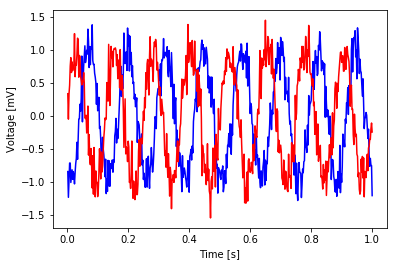

In [6]:
from matplotlib.pyplot import plot, xlabel, ylabel, xlim, ylim
%matplotlib inline
plot(t,E1[0,:], 'b')            # Plot the data from the first trial of one electrode,
plot(t,E2[0,:], 'r')            # ... and the first trial of the other electrode.
xlabel('Time [s]');
ylabel('Voltage [mV]');

Visual inspection of the data in this trial immediately suggests a dominant rhythmic activity occurs in each recording.

<div class="question">
    

**Q.** Approximate the dominant rhythmic activity in each electrode by visual inspection of the figure. A simple procedure is to count the number of peaks in each signal, then divide by the total length of the recording (in this case, 1 s). Does each electrode exhibit approximately the same rhythms? Do you observe similar results in other trials?

    
</div>

These techniques allow us to visualize the data one trial at a time. Doing so is often useful but can be time consuming, especially as the number of trials increases. Here we have 100 trials, and to visualize all of them in this way would require 100 plots. That’s not so bad, but there’s a better way. We can display the entire structure of the data across both time and trials as an image: <a id="fig:image"> 

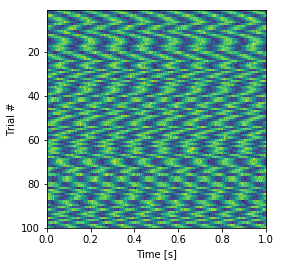

In [7]:
import matplotlib.pyplot as plt
import numpy as np
K = np.shape(E1)[0]                              #Get the number of trials,
plt.imshow(E1,                                   #... and show the image,
           extent=[np.min(t), np.max(t), K, 1],  #... with meaningful axes,
           aspect=0.01)                          #... and a nice aspect ratio.
xlabel('Time [s]')
ylabel('Trial #');

The resulting image for the first electrode is shown in the figure above. Voltage (in color) is plotted as a function of time along the horizontal axis and trial number along the vertical axis. This allows us to visualize the voltage activity of the first electrode for all trials at once.

We notice that each trial exhibits rhythmic structure, which manifests in this image as repeating undulations of blue (low voltage), then red (high voltage) over time. We also observe variability in the alignment of these rhythms from trial to trial; from one trial to the next, the undulations appear not to align.

<div class="question">
    

**Q.** Display an image of the activity for the second electrode and compare it to the image from the first electrode in the figure above. How do the two compare?

    
</div>

Visual inspection of the ECoG data allows us to draw some preliminary conclusions. First, the data appear to be rhythmic, with a particularly strong oscillation near 8 Hz. That’s interesting but not the primary research objective. We would really like to understand whether the activity at the two electrodes is related. Many techniques exist to approach this problem, but let’s begin with the most basic: visual inspection. Let's examine the activity in the first four trials, and attempt to deduce whether a consistent relation exists between the two ECoG signals across trials.

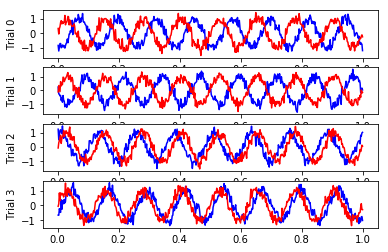

In [8]:
for j in range(4):
    plt.subplot(4,1,j+1)
    plot(t,E1[j,:], 'b')            # Plot the data from trial j of one electrode,
    plot(t,E2[j,:], 'r')            # ... and trial j of the other electrode.
    ylabel('Trial ' + str(j))

We notice in the first two trials that the ECoG activity from the two electrodes appears nearly out of phase (i.e., when the blue curve is near a peak, the red curve is near a trough). However, for the next two trials, activity from the two electrodes nearly overlaps. From this initial visual inspection of four trials, it’s difficult to conclude whether the ECoG activity at the two electrodes is interrelated; both electrodes display rhythmic activity across all trials, but the relation between these rhythms appears to change across trials: sometimes the activities overlap, and sometimes not.

<div class="question">
    
**Q.** Repeat this analysis by examining additional trials, and by inspecting the activity images for each electrode. What conclusions can you make about the relations between the ECoG activity at the two electrodes? Are they related? Are they not related?
    
</div>

Although visual inspection is a useful initial tool for analyzing data, assessing the relations between two electrodes across multiple trials is a difficult task. To go further, we employ a new data analysis tool that builds from the Fourier transform: the coherence.

### Autocovariance and Cross-covariance <a id="Autocovariance-and-Cross-covariance"></a>

In [Analysis of Rhythmic Activity in the Scalp EEG](https://github.com/Mark-Kramer/Case-Studies-Python/tree/master/Analysis%20of%20Rhythmic%20Activity%20in%20the%20Scalp%20EEG), we defined and applied the autocovariance to a single time series and found that this measure helped reveal dependent structure in the data. We could, of course, apply the autocovariance to each ECoG time series considered here. Let’s do so, with a small update to the autocovariance formula that utilizes the trial structure of these data. We define the trial-averaged autocovariance as, <a id="eq:ac"></a>

$$
r_{xx}\big[L\big] = \frac{1}{K} \sum_{k=1}^K \frac{1}{N} \sum_{n=1}^{N-L} (x_{n+L,k} - \bar{x}_k) (x_{n,k} - \bar{x}_k) \, ,
$$
    
where $x_{n,k}$ indicates the data at time index $n$ and trial $k$, and $\bar{x}_k$ is the mean value of $x$ for trial $k$.  Notice that we include a new term $\frac{1}{K} \sum_{k=1}^K$, which instructs us to sum over all trials the autocovariance computed for each trial, and then divide by the total number of trials $K$.  Let's now compute and display the trial-averaged autocovariance for the first electrode in Python<a id="fig:ac"></a>.

<div class="python-note">
    
Note: We could instead write the trial-averaged sample autocovariance because this equation uses the observed data to estimate the theoretical covariance that we would see if we kept repeating this experiment. However, this distinction is not essential to the discussion here.
    
</div>

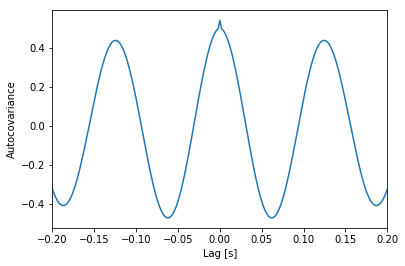

In [9]:
dt = t[1]-t[0]			                # Define the sampling interval.
K = np.shape(E1)[0]			            # Define the number of trials.
N = np.shape(E1)[1]                     # Define number of points in each trial.
ac = np.zeros([2*N-1])                  # Declare empty vector for autocov.

for index,trial in enumerate(E1):		# For each trial,
    x = trial-np.mean(trial)			# ... subtract the mean,
    ac0 =1/N*np.correlate(x,x,2)	    # ... compute autocovar,
    ac += ac0/K;		                # ... and add to total, scaled by 1/K.
    
lags = np.arange(-N+1,N)                # Create a lag axis,
plot(lags*dt,ac)                        # ... and plot the result.
xlim([-0.2, 0.2])
xlabel('Lag [s]')
ylabel('Autocovariance');

<div class="question">
    
**Q.** Consider the results for the trial-averaged autocovariance plotted in the figure [above](#fig:ac). What do these results suggest about the rhythmic structure in these data?

**A:** The trial-averaged autocovariance helps characterize the rhythmic activity at this electrode. Visual inspection of this figure reveals three large positive peaks. The largest peak occurs at a lag of 0 s, as expected; the signal matches itself at zero lag. The two other peaks occur at lags of approximately $\pm 0.125$ s. These peaks reveal that the data, and a version of the data shifted by +0.125 s or -0.125 s, are a good match. Notice that a shift of $\pm 0.125$ s is consistent with periodic activity of approximate frequency 1/(0.125 s) = 8 Hz. For example, imagine a sinusoid of frequency 8 Hz; if we shift the sinusoid by its period (0.125 s) and compare it to the original (unshifted) sinusoid, the match will be excellent. Our data are more complicated than a simple sinusoid, but our visual inspection of the voltage traces ([figure](#fig:traces)) did reveal a dominant 8 Hz rhythm consistent with these autocovariance results.
    
</div>

<div class="question">
    
**Q.** Repeat the analysis to compute the trial-averaged autocovariance for the second electrode. What do you find? How do the trial-averaged autocovariances for the two electrodes compare?
    
</div>

The trial-averaged autocovariance results for each electrode are interesting, but our primary scientific question for these data is whether dependent structure exists *between* the ECoG activity recorded from the two electrodes. In other words, are the time series recorded from the two electrodes coupled? Many tools exist to characterize coupling between time series, and in this module we focus on two such tools.

The first is the **cross-covariance**, $r_{xy}\big[L\big]$, an extension of the autocovariance to include two time series, defined as,

$$
r_{xy}\big[L\big] = \frac{1}{N} \sum_{n=1}^{N-L} (x_{n+L} - \bar{x}) (y_{n} - \bar{y}) \, ,
$$
<a id="eq:xc"></a>

where $x$ and $y$ are two time series with time index $n$.  Notice what we've done;  compared to the autocovarance defined in ([this equation](#eq:ac)), the cross-covariance formula simply replaces the $x$'s in the second term in parentheses with $y$'s.

The intuition for understanding the cross-covariance is similar to that for the autocovariance (see [Analysis of Rhythmic Activity in the Scalp EEG](https://github.com/Mark-Kramer/Case-Studies-Python/tree/master/Analysis%20of%20Rhythmic%20Activity%20in%20the%20Scalp%20EEG)). To calculate the cross-covariance, we multiply $y$ with $x$ shifted in time by lag $L$, as illustrated here:

<img src="imgs/cartoon_xc.png"></img>

Here we show a cartoon representation of the cross-covariance between two time series $x$ and $y$. Data $x$ and $y$ are visualized as one-dimensional vectors, $x$ in black and $y$ in blue. The cross-covariance at (b) lag 0, (c) lag 1, and (d) lag 2 requires different alignments between the two vectors. To compute the cross-covariance at each lag, we multiply the overlapping elements of the two vectors, and sum the product. Non-overlapping elements are not included in the computation.

The cross-covariance is large at lag $L$ if the two shifted time series $x$ and $y$ match. If we’re interested in determining the coupling between $x$ and $y$, finding these matches could be particularly useful. To illustrate an application of the cross-covariance, let’s compute it between the two electrodes during the first trial of the ECoG data: <a id="fig:xc_1">

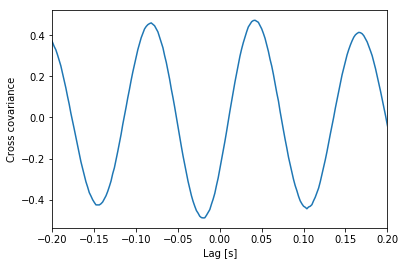

In [10]:
x = E1[0,:] - np.mean(E1[0,:])		# Define one time series,
y = E2[0,:] - np.mean(E2[0,:])		# ... and another.
xc=1/N*np.correlate(x,y,2)	        # ... and compute their cross covariance.
lags = np.arange(-N+1,N)            # Create a lag axis,
plot(lags*dt,xc)					# ... and plot the cross covariance vs lags in time.
xlim([-0.2, 0.2])
xlabel('Lag [s]')					#... with axes labelled.
ylabel('Cross covariance');

Notice that we subtract the mean from each electrode in defining `x` and `y` before computing the cross-covariance using the Python function `correlate` from the `numpy` package. In this case, we supply the `correlate` function with three inputs, beginning with the two time series, `x` and `y`, and setting the `mode` to 2, which tells the function to compute the correlation over the entire extent both vectors.

<div class="question">
    
**Q.** Examine the cross-covariance between the ECoG data from the two electrodes in the first trial ([figure](#fig:xc_1)). What do you observe? At what lags are the largest and smallest values of the cross-covariance? How do these results compare to the trial-averaged autocovariance in [this figure](#fig:ac)? How do these results compare to the voltage traces from each electrode in the first trial ([figure](#fig:traces))?
    
</div>

Like the trial-averaged autocovariance for a single electrode ([here](#fig:ac)), the cross-covariance between the two ECoG electrodes in the first trial reveals periodic variations ([figure](#fig:xc_1)). To understand the structure of this cross-covariance, let’s return to the voltage traces from the two electrodes in this trial,

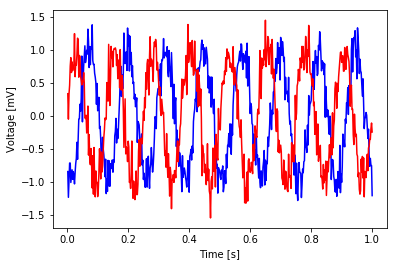

In [11]:
plot(t,E1[0,:], 'b')
plot(t,E2[0,:], 'r')
xlabel('Time [s]');
ylabel('Voltage [mV]');

The largest peak in the cross-covariance occurs near a lag of 0.04 s. Now, imagine shifting the blue time series (corresponding to electrode 1) in this figure by 0.04 s to the left. Doing so, we find that the red and blue traces approximately match; at this lag, when one time series is positive, so is the other, and when one time series is negative, so is the other. Because of this strong match, the cross-covariance is large; the sum in ([this equation](#eq:xc)) at this lag involves many positive terms, so $r_{xy}\big[L\big]$ is a positive number. The largest trough in the cross-covariance occurs near a lag of approximately 0.02 s. To understand this feature, imagine shifting the blue time series in the figure above by 0.02 s to the right. After this shift, the red and blue time series match, but in a different way; when one voltage trace is positive, the other is negative, and vice versa.

<div class="question">
    
**Q.** Continue this exercise of comparing the cross-covariance with the voltage traces in the figure above. At what lags is the cross-covariance near zero? Can you explain these points in terms of shifted versions of the ECoG traces? Can you explain the repeated appearance of peaks (and troughs) at positive and negative lags in terms of shifted versions of the ECoG traces?
    
</div>

Let’s also define the *trial-averaged cross-covariance*. The formula is similar to the trial-averaged autocovariance in ([this equation](#eq:ac)):
$$
r_{xy}\big[L\big] = \frac{1}{K} \sum_{k=1}^K \frac{1}{N} \sum_{n=1}^{N-L} (x_{n+L,k} - \bar{x}_k) (y_{n,k} - \bar{y}_k) \, .
$$
<a id="eq:taxc"></a>
Notice that, compared to the trial-averaged autocovaraince in ([this equation](#eq:taac)), we have replaced the $x$'s in the last term with $y$'s to compute the trial-averaged cross-covariance.  To implement the trial-averaged cross-covariance in Python, consider the following code.

For reference, let's also plot the **single-trial** cross-covaraince for 4 trials,  <a id="fig:avg_xc">

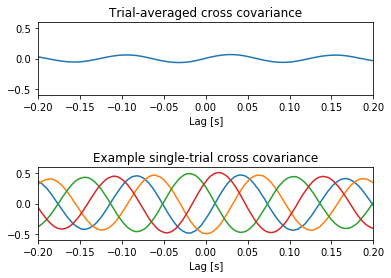

In [12]:
XC = np.zeros([K,2*N-1])                    # Declare empty vector for cross cov.
for k in range(K):			                # For each trial,
    x = E1[k,:]-np.mean(E1[k,:])			# ...get data from one electrode,
    y = E2[k,:]-np.mean(E2[k,:])			# ...and the other electrode,
    XC[k,:]=1/N*np.correlate(x,y,2)         # ...compute cross covariance.
plt.subplot(2,1,1)
plot(lags*dt,np.mean(XC,0))					# Plot cross covariance vs lags in time.
xlim([-0.2, 0.2])
ylim([-0.6, 0.6])
xlabel('Lag [s]')					        #... with axes labelled.
plt.title('Trial-averaged cross covariance');

plt.subplot(2,1,2)
for k in range(4):
    plot(lags*dt,XC[k,:])                   # Also, plot the single-trial cross-covariance for 4 trials
xlim([-0.2, 0.2])
ylim([-0.6, 0.6])
xlabel('Lag [s]')
plt.title('Example single-trial cross covariance');

plt.subplots_adjust(hspace=1)               # Space out the subplots.

The implementation of the trial-averaged cross-covariance is similar to the implementation of the single-trial cross-covariance. The main difference is the inclusion of the `for` statement, which we use to compute and store the cross-covariance of each trial. We then average these results across trials using the `mean` command from the `numpy` package. The trial-averaged cross-covariance (and example single-trial cross-covariances) are plotted in the figure above.

<div class="question">
    
**Q.** Compare the trial-averaged cross-covariance to the example single-trial cross-covariances. What differences and similarities do you notice between the two cross-covariances?


**A.** Perhaps the most striking difference between the two cross-covariances is their magnitude; the single-trial cross-covariances are much larger—approximately an order of magnitude—than the trial-averaged cross-covariance. To understand why this difference occurs, consider the impact of averaging the four example single-trial cross-covariances plotted in the figure above. At each lag, we find both positive and negtive cross-covariance values. We therefore expect that, upon averaging these values across trials, we will obtain a value near zero at each lag. In fact, that’s just what we find in the trial-averaged cross-covariance. Because the single-trial cross-covariance functions lack alignment across trials, the averaging procedure acts to cancel out the individual (large) fluctuations of each single-trial cross-covariance.




We may therefore conclude the following. At the single-trial level we find strong cross-covariance that is periodic with period near 0.125 s (examples in the figure aove). However, we find much weaker trial-averaged cross-covariance; the cross-covariance structure that exists at the single-trial level does not persist when averaged across trials.



Why are the prominent cross-covariance features in the single-trial analysis lost in the trial-averaged cross-covariance? We discuss this issue in more detail in the [Summary](#summary) below.
    
</div>

### Trial-Averaged Spectrum <a id="Trial-Averaged-Spectrum"></a>

One goal of this module is to characterize the relations (if any) between the data recorded at the two ECoG electrodes. To do so, let’s review a vital tool in this characterization, the Fourier transform. We defined in [Analysis of Rhythmic Activity in the Scalp EEG](https://github.com/Mark-Kramer/Case-Studies-Python/tree/master/Analysis%20of%20Rhythmic%20Activity%20in%20the%20Scalp%20EEG) the Fourier transfom of a signal $x$; let's repeat that definition here,

$$
X_j = \sum_{n=1}^N x_n \exp(-2 \pi i \, f_j \, t_n) \, .
$$
<a id="eq:ftCh5"></a>

Remember that $x_n$ is the data evaluated at time index $n$. For the ECoG data of interest here, we have 1 s of data sampled at 500 Hz; therefore $n$ ranges from 1 to $N=500$, and $t_n = \mathrm{dt} \, n$ denotes the discrete time steps, where $\mathrm{dt}$ is the sampling interval. The discrete frequencies are $f_j = j/T$, where $j=\{-N/2+1, -N/2+2, \ldots, N/2-1, N/2\}$.  Replacing the expressions for $f_j$ and $t_n$ with their definitions and simplifying, we can rewrite the equation above as,

$$
X_j = \sum_{n=1}^N x_n \exp(\frac{-2 \pi i}{N} j \, n) \, .
$$
<a id="eq:ftCh5_simp"></a>

In general, $X_j$ can be a complex quantity (i.e., the Fourier transform of $x_n$ can have both real and imaginary parts). We can therefore think of $X_j$ as residing in the two-dimensional complex plane:

<img src="imgs/ex_complex_plane.png", width=300></img>

Points in the complex plane can be specified in two coordinate systems: Cartesian coordinates (gray) or polar coordinates (orange). The [complex plane](https://en.wikipedia.org/wiki/Complex_plane) contains the real part (horizontal axis) and imaginary part (vertical axis) of every point.

As you may remember from a geometry or calculus class, we can represent a point in the plane using another coordinate system: polar coordinates. In polar coordinates, we imagine connecting each point to the origin. The resulting line has a length, called the radius or amplitude, and forms an angle with the real axis, called the phase. Like the real and complex parts, the amplitude and phase uniquely specify each point (almost ...) in the complex plane. These two coordinate systems are shown for an example point in the complex plane in the figure above.

Using polar coordinates, we can then express the complex quantity $X_j$ as,

$$
X_j = A_j \exp(i \phi_j) \, ,
$$
<a id="eq:x_polar"></a>

where $A_j$ is the amplitude and $\phi_j$ is the phase at frequency index $j$.  Notice that both the amplitude and phase are functions of frequency.  Remember that, to compute the spectrum, we multiple the Fourier transform of the data by its complex conjugate, and scale the result. The spectrum of $x_n$ then becomes, 

<a id="eq:Sxx">
$$
\begin{align}
S_{xx, \, j} 	&= \frac{2 \mathrm{dt}^2}{T} X_j X^*_j \label{eq:Sxx} \, , \\
		&= \frac{2 \mathrm{dt}^2}{T} \big(A_j \exp(i \phi_j) \big)  \big(A_j \exp(-i \phi_j) \big) \, ,
\end{align}
$$
</a>

where, to compute the complex conjugate in the second term, we replace $i$ with $-i$.  The last expression simplifies rather nicely,

$$
\begin{align}
S_{xx, \, j}	&= \frac{2 \mathrm{dt}^2}{T} A_j^2  \exp(i \phi_j -i \phi_j) \, , \notag \\
		&= \frac{2 \mathrm{dt}^2}{T} A_j^2  \exp(0) \, , \notag \\
		&= \frac{2 \mathrm{dt}^2}{T} A_j^2 \, .
\end{align}
$$
<a id="eq:pow_A"></a>

This expression provides a new, and perhaps more direct, interpretation of the spectrum as proportional to the squared amplitude of the point $X_j$ in the complex plane. We can extend this simplified expression in one additional way to make explicit the trial structure of the ECoG data analyzed here. Because we possess multiple trials, and we assume that each trial represents an instantiation of the same underlying process, we average the spectra across trials to compute the *trial-averaged spectrum*,

$$
<S_{xx, \, j}> = \frac{2 \mathrm{dt}^2}{T} \frac{1}{K} \sum_{k=1}^K A_{j,k}^2 \, ,
$$
where $k$ indicates the trial number, $K$ the total number of trials, and $A_{j,k}$ the amplitude of the signal at frequency index $j$ and trial index $k$.  Notice how we implement the trial averaging: we simply average the squared amplitude at frequency index $j$ across the $K$ trials.  We use the angular brackets ($< \, >$) to denote that the spectrum ($S_{xx, \, j}$) has been averaged across trials. We can compute the trial-averaged spectrum in Python<a id="fig:trial_avg_spectrum"></a>,

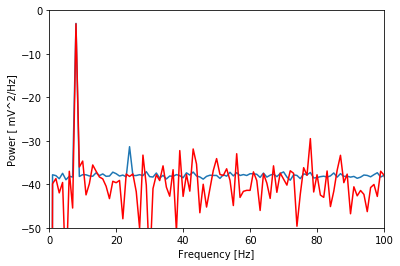

In [13]:
T = t[-1]                                         # Get the total duration of the recording.
Sxx = np.zeros([K,int(N/2+1)])		              # Create variable to store each spectrum.
for k,x in enumerate(E1):				          # For each trial,
    xf  = np.fft.rfft(x-np.mean(x)) 	          # ... compute the Fourier transform,
    Sxx[k,:] = 2*dt**2/T *np.real(xf*np.conj(xf)) # ... and compute the spectrum.
    
f = np.fft.rfftfreq(N, dt)                        # Define a frequency axis

plot(f,10*np.log10(np.mean(Sxx,0)))               # Plot average spectrum over trials in decibels vs frequency,
xlim([0, 100])				                      # ... in select frequency range,
ylim([-50, 0])                                    # ... in select power range,
xlabel('Frequency [Hz]')	                      # ... with axes labelled.
ylabel('Power [ mV^2/Hz]')

plot(f,10*np.log10(Sxx[0,:]), 'r');               # Also, for reference, plot spectrum from the first trial.

<div class="question">
    
**Q:** Are the terms frequency resolution, Nyquist frequency, and decibel familiar to you? Can you define each in words and equations?
**A:** If not, we recommend reviewing the case study in [Analysis of Rhythmic Activity in the Scalp EEG](https://github.com/Mark-Kramer/Case-Studies-Python/tree/master/Analysis%20of%20Rhythmic%20Activity%20in%20the%20Scalp%20EEG).
    
</div>

The resulting trial-averaged spectrum is shown in the figure (blue in the figure above). Compared to the example spectrum from a single trial (red in the figure above), the variability is greatly reduced. By reducing the variability in this way, interesting structure in the data may become more apparent.

<div class="question">
    
**Q.**  Upon examining the trial-averaged spectrum from one electrode, what additional conclusions can you now make about the data beyond visual inspection of the voltage traces? Repeat this computation of the trial-averaged spectrum for the second electrode. What do you find?  *Hint*: The 8 Hz peak is obvious and consistent with our visual inspection of the data. Do you notice any other (smaller) peaks in the trial-averaged spectrum?
    
</div>

[Return to top](#introduction)

# Introduction to the Coherence <a class="anchor" id="sec:coherence"></a>

Coherence is a measure of association between two time series. Briefly:

<div class="python-note">
    
Two signals are coherent at some frequency if there exists a constant phase relation between them at this frequency.
    
</div>

To compute the coherence, we use the [simplified expression for the spectrum](#eq:pow_A) and an additional term, the cross-spectrum.

Consider two signals $x_{n,k}$ and $y_{n,k}$, with time index $n$ and trial index $k$. These signals have corresponding Fourier transforms $X_{j,k}$ and $Y_{j,k}$. Then the trial-averaged cross-spectrum between these two signals is

<a id="eq:cross"></a>
$$
<S_{xy,\, j}> = \frac{2 \mathrm{dt}^2}{T} \frac{1}{K}\sum_{k=1}^K X_{j,k} Y^*_{j,k} \, ,
$$

where compared to [the spectrum](#eq:Sxx) we replace $X^*_j$ with $Y^*_j$ and include the average over the trial index $k$.  Let's modify and clean up this expression by using polar coordinates.  To do so, we'll first define,

$$
Y_{j,k} = B_{j,k} \exp(i \, \theta_{j,k}) \, ,
$$

where $B_{j,k}$ is the amplitude and $\theta_{j,k}$ is the phase at frequency index $j$ and trial index $k$ for the signal $y_{n,k}$. A similar expression exists for $X_{j,k}$, with amplitude $A_{j,k}$ and phase $\phi_{j,k}$. Then, replacing $X_{j,k}$ and $Y^*_{j,k}$ in [the trial-averaged cross-spectrum](#eq:cross) with their polar coordinate expressions, we find,

<a id="eq:cross_spectrum">
$$
<S_{xy,\, j}> = \frac{2 \mathrm{dt}^2}{T} \frac{1}{K} \sum_{k=1}^K A_{j,k} B_{j,k} \exp \big( i \Phi_{j,k} \big) \, ,
$$
</a>

where we have defined the *phase difference* between the two signals as $\Phi_{j,k} = \phi_{j,k} - \theta_{j,k}$. This equation is the trial-averaged cross spectrum of the two signals $x_{n,k}$ and $y_{n,k}$.  We note that the trial-averaged cross spectrum ($<S_{xy,\, j}>$) can be complex (i.e., may have nonzero real and imaginary parts).

At last we define the **coherence**,

<a id="eq:cohr">
$$
\kappa_{xy,\, j} = \frac{ \mid <S_{xy,\, j}> \mid }{ \sqrt{<S_{xx, \, j}>} \sqrt{<S_{yy, \, j}>}} \, ,
$$
</a>

where $\mid <S_{xy,\, j}> \mid$ indicates the magnitude of the trial-averaged cross spectrum.  In words, the coherence is the magnitude of the trial-averaged cross spectrum between the two signals at frequency index $j$ divided by the magnitude of the trial-averaged spectrum of each signal at frequency index $j$.

To further our understanding of the mathematical expression of the coherence in [the equation above](#eq:cohr), let's replace the trial-averaged spectra in the numerator and denominator with their corresponding expressions in polar coordinates,

<a id="eq:cohr_ang">
$$
\kappa_{xy,\, j} = \frac { \biggr\lvert \sum\limits_{k=1}^K A_{j,k} B_{j,k} \exp \big( i \Phi_{j,k} \big) \biggr\rvert }
			       { \sqrt{\sum\limits_{k=1}^K A_{j,k}^2} \,  \sqrt{\sum\limits_{m=1}^K B_{j,m}^2} }
$$
</a>

This expression is complicated.  So, to gain some intuition for the behavior of $\kappa_{xy,\, j}$, let's make the simplifying assumption that at each frequency the amplitude is identical for both signals and all trials, that is, $A_{j,k} = B_{j,k} = C_j$.  Notice that, in using only the expression $C_j$ for the amplitude, we've eliminated the trial index $k$, and only preserved the frequency index $j$. With this simplifying assumption, our expression for the coherence becomes,

<a id="eq:cohr_simp">
$$
\begin{align}
\kappa_{xy,\, j} &= \frac { \biggr\lvert \sum\limits_{k=1}^K C_j \, C_j \exp \big( i \Phi_{j,k} \big) \biggr\rvert }
			         { \sqrt{\sum\limits_{k=1}^K C_j^2}  \sqrt{\sum\limits_{m=1}^K C_j^2} } \, , \notag \\
		    &= \frac{ C_j^2 }{ C_j^2 } \frac{\biggr\lvert \sum\limits_{k=1}^K \exp \big( i \Phi_{j,k} \big) \biggr\rvert}{\sqrt{\sum\limits_{k=1}^K 1}  \sqrt{\sum\limits_{m=1}^K 1} } \, , \notag \\
		    &= \frac{ 1 }{ K }\biggr\lvert \sum_{k=1}^K \exp \big( i \Phi_{j,k} \big) \biggr\rvert \, .
\end{align}
$$
</a>

Under the simplifying assumption that the amplitude is identical at each frequency for both signals and all trials, the coherence simplifies to the last equation in the expression above. In this special case, the expression for the coherence only involves the phase difference between the two signals averaged across trials; the amplitudes in the numerator and denominator have canceled out.

Now, let’s interpret the simplified expression for the coherence. To do so, we consider two scenarios.

## Simple Scenario 1:  Phases align across trials <a id="Simple_Scenario_1"></a>

First, we assume that at a specific frequency index $j$, the two signals possess a *constant* phase difference across trials. Under this assumption, the phase difference in the first trial ($\Phi_{j,1}$) equals the phase difference in the second trial ($\Phi_{j,2}$), which equals the phase difference in the third trial ($\Phi_{j,3}$), and so on for all trials.  To denote this equivalence in the phase difference across trials, let's replace the symbol for the phase difference $\Phi_{j,k}$ with $\Phi_{j,0}$; here, we have replaced the subscript $k$ with the subscript $0$ to remind ourselves that the phase difference does not depend upon the choice of trial. Now consider the expression:

$$
\exp \big( i \Phi_{j,0} \big) \, . \notag
$$

This term defines a point in the complex plane with amplitude 1, which we can visualize as a vector leaving the origin at angle $\Phi_{j,0}$ to the real axis. Consider, for example, the leftmost plot in the figure below:
<img src="imgs/ex_complex_plane_coherence_a.png"></img>

In this cartoon illustration of the complex plane, we plot the phase difference for each trial (orange arrow). In this case, the phase difference is the same across all trials.

The summation of these terms across trials then becomes,

$$
\sum_{k=1}^K \exp \big( i \Phi_{j,0} \big) \, . \notag
$$

This expression defines a sum of vectors in the complex plane, each of radius 1 (indicated by the blue circle in the figure). Because the phase difference is the same for each trial, these vectors point in the same direction for each trial. Then by summing up these vectors end to end across trials, we produce a long vector in the complex plane that terminates far from the origin, as shown in the righmost panel of the figure above.

<div class="question">
    
**Q:** How long is the summed vector in this case?


**A:** We add $K$ vectors (one for each trial) each of length 1, and each pointing in the same direction ($\Phi_{j,0}$).  So the total length of the vector (i.e., the total distance from the origin to the termination point of the summed vector) is $K$.
    
</div>

The [coherence](#eq:cohr_simp) is this vector length, divided by $K$, so we conclude in this case that,

$$
\kappa_{xy,\, j} = 1 \, , \notag
$$

which indicates strong coherence between the two signals.  The strong coherence in this case results from the constant phase relationship between the two signals across trials at frequency index $j$.

<div class="question">
    
**Q:** Does the conclusion $\kappa_{xy,\, j} = 1$ depend upon the value of the phase difference $\Phi_{j,0}$?  For example, does this result require that the phase difference between the two signals in each trial ($\Phi_{j,0}$) equal $0$, or $\pi/4$, or $\pi$?
    
</div>

[Return to top](#introduction)

## Simple Scenario 2: Phases are random across trials <a id="Simple_Scenario_2"></a> 

As a second scenario, consider another specific frequency $j$ in which the two signals have a random phase difference in each trial. In this case, the phase difference can assume any value between $0$ and $2\pi$ for each trial. To visualize this, let’s imagine the phase differences in the complex plane; in this scenario, the vectors point in different (random) directions from trial to trial:

<img src="imgs/ex_complex_plane_coherence_b.png"></img>

<div class="question">
    
**Q:** Consider the sum of these vectors end to end in the complex plane, plotted in the rightmost panel of the figure above. What is the approximate length of this summed vector across trials?


**A:** We expect the length of this vector to be small. Because the angles lack organization from trial to trial, the vectors are equally likely to point in any direction. Therefore, when we sum these vectors across trials, the length fails to accumulate in any particular direction.
    
</div>

Under the simplifying assumption that the amplitude is identical at this frequency for both signals and all trials, the [coherence](#eq:cohr_simp) is this summed vector length, divided by $K$. Our visual inspection of the cartoon in the figure above (rightmost panel) suggests that this summed vector length will be small. Therefore, for this scenario we conclude that,

$$
\kappa_{xy,\, j} \approx 0 \, , \notag
$$

which indicates weak coherence between the two signals.  The weak coherence in this case results from the random phase relationship over trials between the two signals.

# Summary of the coherence <a id="Summary_of_the_coherence"></a>

These two examples illustrate in simplified scenarios the behavior of the coherence. To summarize, the [coherence](#eq:cohr) is a measure of the relationship between $x$ and $y$ at the same frequency.  The coherence ranges between 0 and 1,

$$
0 \leq \kappa_{xy,\, j}  \leq 1 \, , \notag
$$

in which:
- $0$ indicates no coherence between signals $x$ and $y$ at frequency index $j$, and
- 1 indicates strong strong coherence between signals $x$ and $y$ at frequency index $j$.

<div class="python-note">
    
    The coherence is a measure of the phase consistency between two signals at frequency index $j$ across trials.
    
</div>

We note that because computing the coherence requires the Fourier transform, the notions of frequency resolution and Nyquist frequency are identical to those for the spectrum. In other words, the frequency resolution of the coherence is $1/T$, and the Nyquist frequency is half of the sampling frequency; see [Analysis of Rhythmic Activity in the Scalp EEG](https://github.com/Mark-Kramer/Case-Studies-Python/tree/master/Analysis%20of%20Rhythmic%20Activity%20in%20the%20Scalp%20EEG) for details.

<div class="question">
    
**Q.** What are the units of the coherence?
Hint: Consider [this equation](#eq:cohr) for coherence and the units of the terms in the numerator and denominator. You should find that the coherence is unitless.
    
</div>

[Return to top](#introduction)

## Cross-Covariance and Cross-Spectrum <a id="cc_and_cs"></a>
Although we defined the cross-spectrum in [this equation](#eq:cross) and used it to define the coherence in [this equation](#eq:cohr), the cross-spectrum may appear somewhat unmotivated. Fortunately, there is additional insight to be gained. We show [here](https://github.com/Mark-Kramer/Case-Studies-Python/blob/master/Analysis%20of%20Rhythmic%20Activity%20in%20the%20Scalp%20EEG/Supplement.%20Intuition%20behind%20the%20power%20spectral%20density.ipynb) that the spectrum is the Fourier transform of the autocovariance. Conceptually, the spectrum and autocovariance provide a frequency domain and time domain measure of a signal’s rhythms, respectively. In the same way, the cross-spectrum and cross-covariance are partners. 

<div class="python-note">
    
The cross-spectrum is the Fourier transform of the cross-covariance.
    
</div>

The cross-spectrum and cross-covariance form a Fourier transform pair. The cross-spectrum is a frequency domain measure of coupling, while the cross-covariance is a time domain measure of coupling. To move back and forth between these two measures, we use the Fourier transform. In practice, we rarely examine the cross-spectrum directly; it’s a complex quantity and so requires two dimensions (i.e., the complex plane) to visualize. However, the cross-spectrum is fundamental to the coherence, so in that sense it’s an important actor in the analysis.


[Return to top](#introduction)

## Computing the Coherence <a id="computing_coherence"></a>
With that introduction, we are now equipped to compute the coherence. We expect the coherence to reveal the frequencies at which the two ECoG signals exhibit a constant phase relation across trials.

<div class="question">
    
**Q.** Before we compute the coherence, hypothesize whether you expect to observe coherence between the two ECoG signals. If so, at what frequencies? Your hypothesis should be based on the previous visual analysis and spectral analysis of these data (see, for example, [this figure](#fig:traces) and [this figure](#fig:trial_avg_spectrum)).
    
</div>

<div class="question">
    
**Q.** To plot the coherence versus frequency, we must identify the frequency resolution and Nyquist frequency appropriate for the analysis of the ECoG data. What are they?
    
</div>

There are a variety of alternatives to compute the coherence. To start, let’s compute the coherence by hand. The reason for doing so is that we can implement the preceding mathematical expressions and in that way gain more understanding of their features. Here’s the Python code<a id="fig:cohr"></a>:

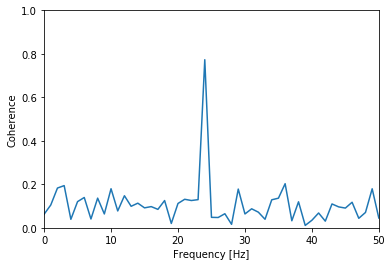

In [14]:
Sxx = np.zeros([K,int(N/2+1)])		              # Create variables to save the spectra,
Syy = np.zeros([K,int(N/2+1)])
Sxy = np.zeros([K,int(N/2+1)], dtype=complex)
for k in range(K):			                      # For each trial,
    x=E1[k,:]-np.mean(E1[k,:])                    # Get the data from each electrode,
    y=E2[k,:]-np.mean(E2[k,:])
    xf  = np.fft.rfft(x-np.mean(x))               # ... compute Fourier transform,
    yf  = np.fft.rfft(y-np.mean(y))
    Sxx[k,:] = 2*dt**2/T *np.real(xf*np.conj(xf)) # ... and compute the spectra.
    Syy[k,:] = 2*dt**2/T *np.real(yf*np.conj(yf))
    Sxy[k,:] = 2*dt**2/T *       (xf*np.conj(yf))

Sxx = np.mean(Sxx,0)		                      # Average the spectra across trials,
Syy = np.mean(Syy,0)
Sxy = np.mean(Sxy,0)

cohr = np.abs(Sxy) / (np.sqrt(Sxx) * np.sqrt(Syy))# ... and compute the coherence.

plot(f, cohr);		                              # Plot coherence vs frequency,
xlim([0, 50])			                          # ... in chosen frequency range,
ylim([0, 1])                                      # ... with y-axis scaled,
xlabel('Frequency [Hz]')                          # ... and with axes labelled.
ylabel('Coherence');

<div class="question">
    
**Q.** That’s quite a bit of code. Look through it line by line, and confirm that each step makes sense. Can you identify the calculation of the cross-spectrum? of the trial averaging?
    
</div>

<div class="question">
    
**Q:** Consider the coherence between the two ECoG electrodes plotted in the figure above. At what frequencies do strong coherences appear? How do these frequencies compare to the trial-averaged spectra, shown for one electrode in [this figure](#fig:trial_avg_spectrum)?


**A:** The coherence measures the phase consistency at a chosen frequency between two signals across trials. For the ECoG data, both electrodes possess trial-averaged spectra with similar features: a large peak near 8 Hz and a smaller peak near 24 Hz (see the trial-averaged spectrum for one electrode in [this figure](#fig:trial_avg_spectrum)). However, the coherence between the two ECoG signals reveals a peak only at 24 Hz. We conclude that the two ECoG signals both exhibit a dominant oscillation at 8 Hz, yet this rhythm is not coherent across trials; only the smaller-amplitude rhythm at 24 Hz is coherent between the two electrodes.
    
</div>

## Visualizing the Phase Difference across Trials <a id="Visualizing_the_Phase_Difference"></a>

The coherence results suggest for the two ECoG recordings a constant phase relation across trials at 24 Hz and a random phase relation across trials at 8 Hz. To further explore these relations, let’s visualize the distribution of phase differences at the two frequencies, as implemented in the following Python code:

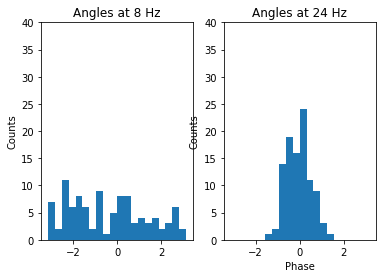

In [15]:
j8 = np.where(f==8)[0][0]	         # Determine index j for frequency 8 Hz.
j24= np.where(f==24)[0][0]	         # Determine index j for frequency 24 Hz.

phi8=np.zeros(K)		             # Variables to hold phase differences.
phi24=np.zeros(K)

for k in range(K):			         # For each trial, compute the cross spectrum. 
    x=E1[k,:]-np.mean(E1[k,:])       # Get the data from each electrode,
    y=E2[k,:]-np.mean(E2[k,:])
    xf  = np.fft.rfft(x-np.mean(x))  # ... compute the Fourier transform,
    yf  = np.fft.rfft(y-np.mean(y))
    Sxy = 2*dt**2/T *(xf*np.conj(yf))# ... and the cross-spectrum,
    phi8[k]  = np.angle(Sxy[j8])	 # ... and the phases.
    phi24[k] = np.angle(Sxy[j24])

plt.subplot(1,2,1)                   # Plot the distributions of phases.
plt.hist(phi8, bins=20, range=[-np.pi, np.pi])
ylim([0, 40])
ylabel('Counts')
plt.title('Angles at 8 Hz')
plt.subplot(1,2,2)
plt.hist(phi24, bins=20, range=[-np.pi, np.pi])
ylim([0, 40])
plt.title('Angles at 24 Hz')
ylabel('Counts')
xlabel('Phase');

Again, we’re encountering quite a bit of Python code. Fortunately, large chunks of this code are familiar. We reuse useful quantities, like the number of trials (`K`) and the frequency axis (`f`). Then, within the frequency axis variable (`f`), we use the function `np.where` to identify the indices corresponding to a frequency of 8 Hz and a frequency of 24 Hz. For each trial, we then compute the cross-spectrum (`Sxy`). The cross-spectrum is a complex quantity at each frequency, and we identify the angle in the complex plane corresponding to the frequencies 8 Hz and 24 Hz using the Python function `np.angle`. We store these results in two vectors, `phi8` and `phi24`.

To summarize the results, we plot a histogram of the phase differences. We divide the phase axis into 20 bins of equal size from 0 to 2$\pi$ radians, or equivalently, 0 to 360 degrees. At 8 Hz, we observe that phase differences appear in all angular intervals; notice that the number of phase differences located in each angular interval remains small, typically less than 10. At 24 Hz, the angular differences concentrate near 0 degrees; all of the angles lie between  approximately 60 and 60 degrees. This visualization is consistent with the strong coherence at 24 Hz, indicative of a consistent phase difference across trials between the two electrodes.

<div class="question">
    
**Q.** Compute and display the distribution of phase differences at other frequencies. What do you find? Are these results consistent with the coherence plotted in [this figure](#fig:cohr)?
    
</div>

## Single-Trial Coherence <a id="single_trial_coherence"></a>

We have emphasized that coherence is a measure of phase consistency between two signals at some frequency *across trials*. This type of analysis is appropriate in many instances in which data are collected in a trial structure. However, we might also be interested in computing the coherence between two signals recorded in a single observation or trial.

<div class="question">
    
**Q:** Is it possible? Can we compute the coherence between two signals for a single trial?
    
</div>

To address this question, consider the [equation for the coherence written in polar coordinates](#eq:cohr_ang).  Remember that, in writing this equation, we have made no assumptions about the data;  instead, all we have done is express the complex quantities in polar coordinates.  Now consider this equation for the case in which we possess only one trial, so that $K=1$.  Then,

$$
\kappa_{xy,\, j} = \frac { \biggr\lvert A_{j,1} B_{j,1} \exp \big( i \Phi_{j,k} \big) \biggr\rvert }
			       { \sqrt{A_{j,1}^2}  \sqrt{B_{j,1}^2} }
		     = \biggr\lvert \exp \big( i \Phi_{j,k} \big) \biggr\rvert = 1 \, .
$$

So, we find here perfect coherence ($\kappa_{xy,\, j}=1$) for any choice of signals $x$ and $y$ and for any frequency (index $j$).  For example, we could choose $x$ to be the price of a publicly traded stock (e.g., GE) and $y$ to be an ECoG recording, both sampled at 500 Hz for 1 s.  Even in this case, we will find perfect coherence between the two signals.

<div class="question">
    
**Q:** Can we use an ECoG signal to predict the stock price of GE? If so, then we’re rich! How can any two arbitrary signals be perfectly coherent at all frequencies?
    
</div>

The answer is that the coherence measure requires a trial structure. Recall that the coherence measures the phase consistency between two signals *across trials*. If only one trial is observed, then the two signals are trivially coherent; the two signals have some phase difference between 0 and 2$\pi$ and because we have no other trials with which to compare this difference, the two signals are “coherent.”

But what if we only collect one trial of data? We can still attempt to compute the coherence in (at least) two ways. First, we could divide the single trial of data into smaller intervals and then treat each interval as a trial. This approach can be effective if we believe the phase relation persists in time, and if we possess a long enough recording. Note that by dividing the data into smaller intervals, we impact the frequency resolution.

<div class="question">
    
**Q:** Imagine we collect 10 s of ECoG data (sampling frequency 500 Hz) from two electrodes and would like to compute the coherence. To do so, we divide the data into ten nonoverlapping 1 s intervals, and treat each interval as a trial to compute the coherence. What is the frequency resolution of the coherence? If instead we divide the data into 100 nonoverlapping frequency intervals, what is the frequency resolution? In both cases, what is the Nyquist frequency?
    
</div>

A second approach to compute the coherence from a single trial of data is to use the [multitaper method](https://en.wikipedia.org/wiki/Multitaper). In this case, each taper acts like a trial. Therefore, to acquire more trials for an accurate estimate of the coherence, we include more tapers. But, by increasing the number of tapers, we worsen the frequency resolution. Because the ECoG data of interest here consist of multiple trials, we do not focus on measures of single-trial coherence.

## Relation between Statistical Modeling and Coherence <a id="Relation_between_Statistical_Modeling_and_Coherence"></a>

Before concluding the discussion of coherence, let’s briefly consider a complementary statistical modeling approach. In developing this statistical model, our goal is to capture the (linear) relation between two signals $x$ and $y$ observed simultaneously for multiple trials. We begin by proposing a statistical model that predicts one signal ($y$) as a linear function of the other ($x$):

$$
\begin{align*}
y_n	&= \sum\limits_{m = -\infty}^{\infty} \beta_m x_{n-m} + \epsilon_n \, , \\
	&= (\beta \star x)\big[n\big] + \epsilon_n \, ,
\end{align*}
$$

where we express the predicted signal ($y_n$) as a function of $x_n$, coefficients $\beta_m$, and a Gaussian noise term $\epsilon_n$, and where $n$ is a discrete time index.  Notice that, in the first equation, the summation limits indicate that the predicted signal at time index $n$ may depend on $x$ at any past or future time.  The second equality above expresses the summed product of $\beta$ and $x$ as their convolution.  Taking the Fourier transform of both sides of this equation, and noting that convolution in the time domain is equivalent to multiplication in the frequency domain, we find,

$$
\begin{align*}
Y_j	&= \gamma_j X_j + \Upsilon_j \, ,
\end{align*}
$$

where $Y_j$ is the Fourier transform of $y_n$,
	$\gamma_j$ is the Fourier transform of $\beta_n$,
	$X_j$ is the Fourier transform of $x_n$,
	$\Upsilon_j$ is the Fourier transform of $\epsilon_n$,
and $j$ indicates a discrete frequency index.  Multiplying both sides of this equation by the complex conjugate of the Fourier transform of $x$,

$$
\begin{align*}
Y_j \, X_j^*	&= \gamma_j X_j \, X_j^*+ \Upsilon_j \, X_j^* \, ,
\end{align*}
$$

and averaging this result across the trials of data, we find,

$$
\begin{align*}
< Y_j \, X_j^* >	&= \gamma_j < X_j \, X_j^*> + < \Upsilon_j \, X_j^*> \, ,
\end{align*}
$$

where we have used the notation $< \, >$ to indicate the trial average.
Assuming that the noise term and signal $x$ are unrelated, their trial average is zero (i.e.,  $ < \Upsilon_j \, X_j^*> = 0$).  Solving for $\gamma_j$ we find,

$$
\begin{align}
\gamma_j  	&= \dfrac{< Y_j \, X_j^* >}{< X_j \, X_j^*>} \, , \notag \\
			&= \dfrac{< S_{xy,j} >}{< S_{xx,j} >} \, . \label{eq:model_coherence}
\end{align}
$$

Then, comparing this expression to the [equation for coherence](#eq:cohr) we find,

$$
\begin{align}
\kappa_{xy,\, j} =  \mid \gamma_j \mid \dfrac{\sqrt{<S_{xx, \, j}>}}{\sqrt{<S_{yy, \, j}>}} \, .
\end{align}
$$

We conclude that the coherence ($\kappa_{xy,\, j}$) is a scaled version of the frequency domain representation of the statistical model coefficients ($\gamma_j$) for predicting $y$ from $x$. We note that $\gamma_j$ is a complex quantity that allows us to model both the magnitude and phase of the relationship between $x$ and $y$.  The phase difference computed from the model and the coherence is the same as well.

# Summary <a id="summary"></a>

In this module, we analyzed ECoG data recorded from two electrodes during an auditory task. The task involved the repeated presentation of auditory stimuli, resulting in 100 trials of 1 s duration recorded simultaneously from the two electrodes. We began the analysis with visual inspection of individual trials and of all trials at once. Then, to assess the relations between the two recordings, we computed the cross-covariance. We discussed how the cross-covariance is an extension of the autocovariance, and found that the single-trial cross-covariance between the ECoG signals exhibited periodic structure, consistent with rhythmic coupling of period 0.125 s. However, the trial-averaged cross-covariance provided less evidence for consistent rhythmic coupling across trials. We then computed the trial-averaged spectrum and found a large peak near 8 Hz and a much smaller peak near 24 Hz.

To further assess the relation between the two electrodes, we computed the coherence. The coherence is strong (approaches 1) at a chosen frequency $f_0$ when there exists a constant phase relation at frequency $f_0$ between two electrodes over trials. We found a strong coherence between the two ECoG electrodes only at 24 Hz. We concluded that although both ECoG signals possessed dominant rhythms at 8 Hz, these rhythms were not coherent between the two electrodes. The strong coherence appeared only at the small-amplitude 24 Hz rhythm. Finally, we implemented a technique to visualize the distribution of phase differences between the two electrodes across trials, and provided some suggestions for how to compute the coherence for a single trial of data.

<div class="python-note">
    
**Caution!** Large amplitude does not imply large coherence.
    
</div>

In this example, only the coherence revealed the low-amplitude coupling at 24 Hz between the two ECoG electrodes. This coupling was not obvious in the single-trial or trial-averaged cross-covariance. In fact, the single-trial cross-covariance was deceiving; we found [strong single-trial cross-covariance](#fig:xc_1) with period 0.125 s, or 8 Hz, yet no coherence at 8 Hz.

To understand this discrepancy, consider two unrelated signals, each dominated by the same rhythm. By unrelated we mean that the signals do not communicate in any way. Yet both are rhythmic and happen to oscillate at the same frequency. If we compute the cross-covariance between these two unrelated signals, we will find periodic lags at which the two signals nearly overlap and the cross-covariance is large. The period of these cross-covariance peaks corresponds to the period of the common rhythm shared by the two signals. Here the periodic, large cross-covariance values occur because the two signals happen to both exhibit a similar rhythm, not because one signal influences the other.

This example illustrates a point of caution in the interpretation of cross-covariance results. Unrelated signals that happen to share a similar dominant rhythm will exhibit large periodic structure in the cross-covariance. One approach to defend against such cross-covariance results is to compute the trial-averaged cross-covariance. If two signals are unrelated—to one another and to the trial structure—then we do not expect similar cross-covariance functions across trials. Therefore, although each single-trial cross-covariance may have large values at some lags, their average across trials will be small. This is [just what we found](#fig:avg_xc) for the ECoG data examined here. We note that the unrelated 8 Hz signals, which dominate the ECoG activity at each electrode, mask the much smaller amplitude 24 Hz activity that is coupled between the two electrodes. The coupling at 24 Hz is not apparent in the [trial-averaged cross-covariance](#fig:avg_xc). The coherence, which normalizes by the power at each frequency, uncovers this relation.


As is true for the Fourier transform and spectrum, there exists a vast literature on computing and interpreting the coherence. Some references for further reading include:

- [Percival & Walden, 1993](https://www.cambridge.org/core/books/spectral-analysis-for-physical-applications/A9195239A8965A2C53D43EB2D1B80A33)

- [Priestly, 1982](https://www.elsevier.com/books/spectral-analysis-and-time-series-two-volume-set/priestley/978-0-08-057055-6)

- [Numerical recipes](http://numerical.recipes/)

In [16]:
from IPython.core.display import HTML
HTML('../../assets/custom/custom.css')